In [1]:
# -*- coding: utf-8 -*-
from __future__ import print_function
import datetime

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
# load data into DataFrames
files = ['../data/processed/data_clean_Thang_Kaar_Baen_4185.csv',
         '../data/processed/data_clean_Thang_Kaar_Dorje_4014.csv']

dfs = []
for f in files:
    dfs.append(pd.read_csv(f, index_col='EventID'))

In [97]:
import sklearn
from sklearn import svm
from sklearn import ensemble
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectKBest

In [141]:
# helper functions
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          print_cm=False,
                          display_colorbar=False):
    """
    From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    if display_colorbar:
        plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if print_cm:
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Feature selection
Which variables show the highest discriminative power, and thus should be kept in the model selection process to avoid overfitting?

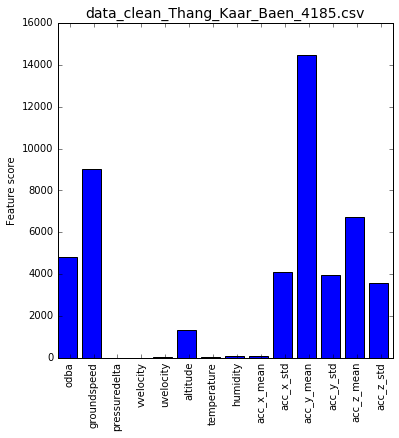

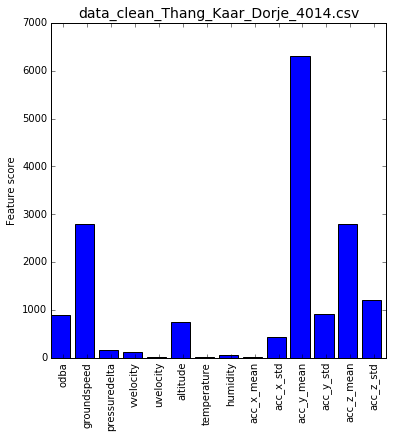

In [147]:
for (idx, df) in enumerate(dfs):
    var_names = [col for col in df.columns if col not in ['dt', 'state']]
    data = df[var_names].as_matrix()
    target = df['state'].as_matrix()
    selector = SelectKBest()
    selector.fit(data, target)

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    plt.bar(range(len(var_names)), selector.scores_)
    plt.xticks([x+0.5 for x in range(len(var_names))], var_names, rotation='vertical')
    ax.set_ylabel('Feature score')
    ax.set_title(files[idx].split('/')[-1], {'fontsize': 14})

    plt.show()

Clearly 8 features (the acceleration ones, ODBA, altitude, and groundspeed), are much more helpful than the rest in determining the state.

In [148]:
selector = SelectKBest(k=8)
selector.fit(data, target)
var_names_best = list(np.array(var_names)[selector.get_support()])

In [149]:
df['state'].value_counts()

Rest          2719
Fly           1081
Restless       389
Others          45
Flap_fligh      16
WHR             13
Feed             3
Flap_land        2
Flap_takeo       1
Name: state, dtype: int64

We now have 8 features, and roughly as many records for several classes: Flap-flight, Feed, Flap-land, Flap-takeoff.  The model will have a hard time generalising from so few examples. In addition, unspecific classes (Others, Restless, WHR) should be removed.

### Simple support vector machine, with no hyperparameter tuning

For now, we train and evaluate models on the larger dataset (tag 4185, 13500 samples)

In [209]:
df = dfs[0]
df = df[~df.state.isin(['WHR', 'Others', 'Restless'])]
data = df[[col for col in df.columns if col in var_names_best]].as_matrix()
target = df['state'].as_matrix()

              precision    recall  f1-score   support

        Feed       0.00      0.00      0.00        20
 Flap-flight       0.00      0.00      0.00        25
   Flap-land       0.00      0.00      0.00        12
Flap-takeoff       0.00      0.00      0.00        10
         Fly       0.83      1.00      0.90      1565
        Rest       1.00      0.95      0.97      5158

 avg / total       0.95      0.95      0.95      6790



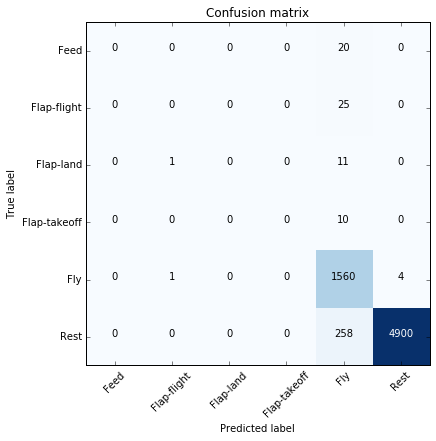

In [153]:
clf = svm.SVC(class_weight='balanced')

X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=0.5, test_size=0.5)

clf.fit(X_train, y_train)

expected = y_test
predicted = clf.predict(X_test)
cr = metrics.classification_report(expected, predicted)
cm = metrics.confusion_matrix(expected, predicted)

print(cr)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, classes=sorted(np.unique(target)));

The naive model is having a very tough time telling apart the "active" classes, and classifies everything that is not rest as "Fly". Let's try a more sophisticated model, a gradient booster.

              precision    recall  f1-score   support

        Feed       0.79      0.55      0.65        20
 Flap-flight       0.50      0.36      0.42        25
   Flap-land       0.12      0.08      0.10        12
Flap-takeoff       0.09      0.20      0.13        10
         Fly       0.99      0.99      0.99      1565
        Rest       1.00      1.00      1.00      5158

 avg / total       0.99      0.99      0.99      6790



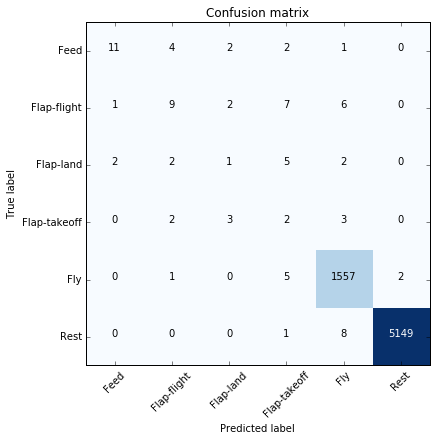

In [155]:
clf = ensemble.GradientBoostingClassifier()

clf.fit(X_train, y_train)

expected = y_test
predicted = clf.predict(X_test)
cr = metrics.classification_report(expected, predicted)
cm = metrics.confusion_matrix(expected, predicted)

print(cr)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, classes=sorted(np.unique(target)));

Even a naive (non-tuned) GB performs much better than a support vector classifier, probably because the classes are not easily separable with a hyperplane (especially the in-flight classes). Now we need to perform cross-validation with hyperparameter tuning to see how far we can take the classification.

In [216]:
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV

First grid search to determine the optimal learning rate/number of estimators combination

In [234]:
clf = ensemble.GradientBoostingClassifier(subsample=0.8)
score_metric = 'f1_weighted'
params = {'n_estimators':range(10,21,2), 'learning_rate': np.arange(0.02, 0.15, 0.04)}
gsearch = GridSearchCV(estimator = clf, param_grid = params, scoring=score_metric, n_jobs=4, cv=10)
gsearch.fit(data,target)
print('Best parameters: %s' % gsearch.best_params_)
print('Score (%s) with these parameters: %0.6f' % (score_metric, gsearch.best_score_))

/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters: {'n_estimators': 10, 'learning_rate': 0.13999999999999999}
Score (f1_weighted) with these parameters: 0.993326


With these parameters set, we learn iteratively tree-specific hyperparameters

In [235]:
clf = ensemble.GradientBoostingClassifier(subsample=0.8, n_estimators=10, learning_rate=0.14)

params = {'max_depth':range(2,11,2), 'min_samples_split':range(2,11,2)}
gsearch = GridSearchCV(estimator = clf, param_grid = params, scoring=score_metric, n_jobs=4, cv=10)
gsearch.fit(data,target)
print('Best parameters: %s' % gsearch.best_params_)
print('Score (%s) with these parameters: %0.6f' % (score_metric, gsearch.best_score_))

/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters: {'min_samples_split': 4, 'max_depth': 4}
Score (f1_weighted) with these parameters: 0.993192


The last step is making the model incrementally more robust by decreasing the subsample fraction

In [252]:
clf = ensemble.GradientBoostingClassifier(n_estimators=10, learning_rate=0.14, min_samples_split=4, max_depth=4)

params = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch = GridSearchCV(estimator = clf, param_grid = params, scoring=score_metric, n_jobs=4, cv=10)
gsearch.fit(data,target)
print('Best parameters: %s' % gsearch.best_params_)
print('Score (%s) with these parameters: %0.6f' % (score_metric, gsearch.best_score_))

/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters: {'subsample': 0.85}
Score (f1_weighted) with these parameters: 0.993312


Now we have an optimally tuned model, even though the tuning did little to affect the score. Let's see how it performs on the same train/test set as before.

              precision    recall  f1-score   support

        Feed       0.87      0.65      0.74        20
 Flap-flight       0.82      0.36      0.50        25
   Flap-land       0.15      0.17      0.16        12
Flap-takeoff       0.11      0.20      0.14        10
         Fly       0.99      0.99      0.99      1565
        Rest       1.00      1.00      1.00      5158

 avg / total       0.99      0.99      0.99      6790



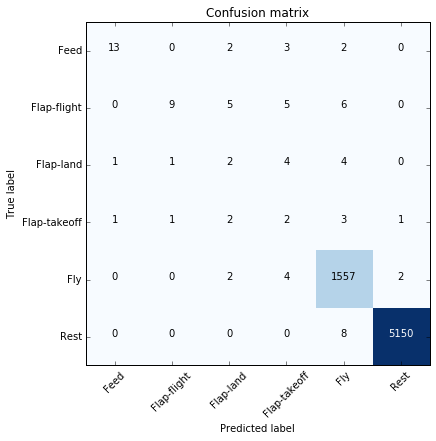

In [259]:
clf_opt_tag_4185 = ensemble.GradientBoostingClassifier(subsample=0.85, n_estimators=10, learning_rate=0.14,
                                                       min_samples_split=4, max_depth=4)

clf_opt_tag_4185.fit(X_train, y_train)

expected = y_test
predicted = clf_opt_tag_4185.predict(X_test)
cr = metrics.classification_report(expected, predicted)
cm = metrics.confusion_matrix(expected, predicted)

print(cr)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, classes=sorted(np.unique(target)));

### The curse of imbalanced data: simulating performance gains on balanced classes

Having imbalanced classes (many more observations resting than feeding, for example), penalises the performance of a model. What would the classification look like on a synthetic data set with the rare observations made artificially more common by either resampling them with replacement, or sampling from their estimated distribution over all features?

In [196]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

#### Resampling with replacement (simplistic assumption)

In [246]:
data_rs, target_rs = RandomOverSampler().fit_sample(data, target)

pd.Series(target_rs).value_counts()

Flap-takeoff    10392
Flap-land       10392
Fly             10392
Feed            10392
Rest            10392
Flap-flight     10392
dtype: int64

Now all classes have an equivalent frequency.

              precision    recall  f1-score   support

        Feed       0.99      0.96      0.98      5223
 Flap-flight       0.89      0.88      0.88      5224
   Flap-land       0.83      0.92      0.88      5202
Flap-takeoff       0.84      0.79      0.81      5168
         Fly       0.98      0.97      0.97      5220
        Rest       1.00      1.00      1.00      5139

 avg / total       0.92      0.92      0.92     31176



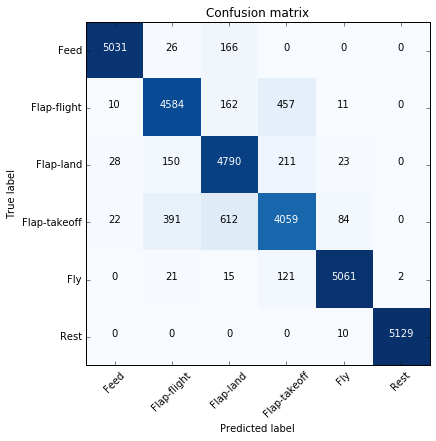

In [260]:
X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(data_rs, target_rs, train_size=0.5, test_size=0.5)

clf_opt_tag_4185.fit(X_train_rs, y_train_rs)

expected = y_test_rs
predicted = clf_opt_tag_4185.predict(X_test_rs)
cr = metrics.classification_report(expected, predicted)
cm = metrics.confusion_matrix(expected, predicted)

print(cr)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, classes=sorted(np.unique(target)));

#### Resampling from estimated underlying distribution (better assumption)

In [248]:
data_rs, target_rs = SMOTE().fit_sample(data, target)
data_rs, target_rs = SMOTE().fit_sample(data_rs, target_rs)  # SMOTE supports two classes only, 
data_rs, target_rs = SMOTE().fit_sample(data_rs, target_rs)  # so we need to call it multiple times.
data_rs, target_rs = SMOTE().fit_sample(data_rs, target_rs)
data_rs, target_rs = SMOTE().fit_sample(data_rs, target_rs)

              precision    recall  f1-score   support

        Feed       0.99      0.96      0.98      5181
 Flap-flight       0.88      0.88      0.88      5144
   Flap-land       0.85      0.92      0.88      5143
Flap-takeoff       0.85      0.80      0.82      5158
         Fly       0.98      0.97      0.97      5216
        Rest       1.00      1.00      1.00      5334

 avg / total       0.92      0.92      0.92     31176



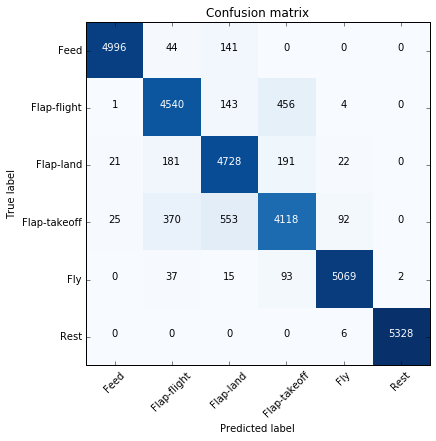

In [261]:
clf_rs = ensemble.GradientBoostingClassifier()

X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(data_rs, target_rs, train_size=0.5, test_size=0.5)

clf_opt_tag_4185.fit(X_train_rs, y_train_rs)

expected = y_test_rs
predicted = clf_opt_tag_4185.predict(X_test_rs)
cr = metrics.classification_report(expected, predicted)
cm = metrics.confusion_matrix(expected, predicted)

print(cr)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, classes=sorted(np.unique(target)));

With both resampling methods, we observe that the performance of the optimised model is now much higher, with the classification errors more evenly distributed across the dataset (we've artificially penalised the model for class imbalance), and the confusion matrix helps to see which classes are still hard to tell apart.
The 3 flap flight classes (especially take-off and land) are the only ones that regularly get mixed up; on other classes, the classification is near perfect, demonstrating the advantage of having a more balanced data set.

### Generalising to multiple individuals

Let's take the model trained on the first individual, and see how it performs to classify the behaviour of another invidiual (here 4014).

In [267]:
df = dfs[1]
df = df[~df.state.isin(['WHR', 'Others', 'Restless'])]
data_4014 = df[[col for col in df.columns if col in var_names_best]].as_matrix()
target_4014 = df['state'].as_matrix()

target_4014[target_4014=='Flap_fligh'] = 'Flap-flight'
target_4014[target_4014=='Flap_land'] = 'Flap-land'
target_4014[target_4014=='Flap_takeo'] = 'Flap-takeoff'

              precision    recall  f1-score   support

        Feed       1.00      0.33      0.50         3
 Flap-flight       0.00      0.00      0.00        16
   Flap-land       0.07      0.50      0.12         2
Flap-takeoff       0.03      1.00      0.06         1
         Fly       1.00      0.96      0.98      1081
        Rest       1.00      1.00      1.00      2719

 avg / total       0.99      0.99      0.99      3822



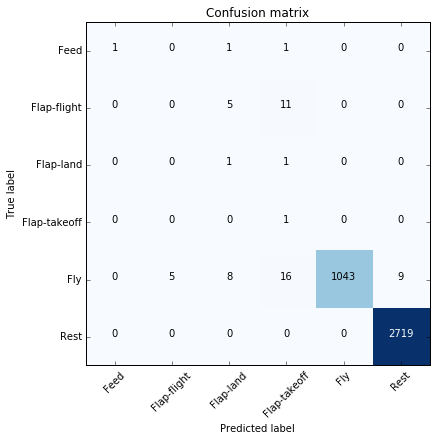

In [270]:
expected = target_4014
predicted = clf_opt_tag_4185.predict(data_4014)
cr = metrics.classification_report(expected, predicted)
cm = metrics.confusion_matrix(expected, predicted)

print(cr)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, classes=sorted(np.unique(target_4014)));

Remarkably, much of the accuracy on the classes outside of flap flight is preserved. Lastly, what happens if we retrain the model on data from the new individual?

              precision    recall  f1-score   support

        Feed       1.00      1.00      1.00         1
 Flap-flight       0.67      1.00      0.80         8
   Flap-land       0.00      0.00      0.00         2
Flap-takeoff       0.00      0.00      0.00         1
         Fly       1.00      0.98      0.99       570
        Rest       0.99      1.00      1.00      1329

 avg / total       0.99      0.99      0.99      1911



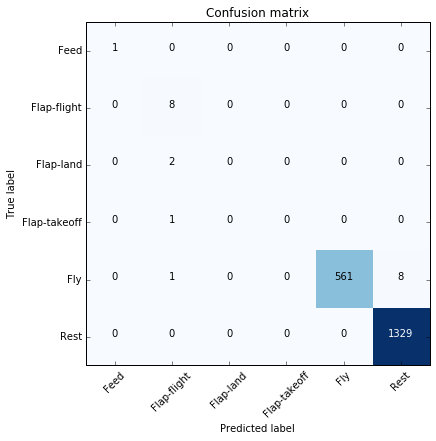

In [278]:
X_train_4014, X_test_4014, y_train_4014, y_test_4014 = train_test_split(data_4014, target_4014, train_size=0.5, test_size=0.5)

clf_opt_tag_4185.fit(X_train_4014, y_train_4014)

expected = y_test_4014
predicted = clf_opt_tag_4185.predict(X_test_4014)
cr = metrics.classification_report(expected, predicted)
cm = metrics.confusion_matrix(expected, predicted)

print(cr)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, classes=sorted(np.unique(target)));

Unfortunately, the number of events in most of the classes of this dataset is too low.

In [279]:
pd.Series(target_4014).value_counts()

Rest            2719
Fly             1081
Flap-flight       16
Feed               3
Flap-land          2
Flap-takeoff       1
dtype: int64

As a consequence, the model is unable to learn outside of the main classes. However, the similar performance on these classes (mainly fly and rest) for the model trained on this individual's data and on the other individual's data, shows that there is potential for generalisation to multiple individuals. Much attention should then be paid to the standardisation of features, so that the idiosyncracies of each recording setup (tag calibration etc.) do not affect the performance of the classifier.